In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input, GlobalMaxPooling1D, BatchNormalization, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from pprint import pprint
from numba import cuda 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def release_gpu_memory():
    device = cuda.get_current_device()
    device.reset()

In [3]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [4]:
df = pd.read_csv('cleaned_reviews_final.csv')

In [5]:
df.head()

,Unnamed: 0,review,ratings,processed_reviews
0,0,The Shawshank Redemption is written and direct...,5.0,shawshank redempt written direct frank darabon...
1,1,Why do I want to write the 234th comment on Th...,10.0,want write th comment shawshank redempt sure a...
2,2,"In its Oscar year, Shawshank Redemption (writt...",10.0,oscar year shawshank redempt written direct fr...
3,3,I'm trying to save you money; this is the last...,10.0,tri save money last film titl consid borrow re...
4,4,I have never seen such an amazing film since I...,10.0,never seen amaz film sinc saw shawshank redemp...


In [6]:
df.drop(columns=['Unnamed: 0', 'review'], inplace=True)

In [7]:
df.dtypes

ratings              float64
processed_reviews     object
dtype: object

In [8]:
df.ratings.value_counts()

1.0     26573
10.0    17119
5.0     10025
9.0      5844
8.0      3763
2.0      3606
3.0      2902
7.0      2664
6.0      2355
4.0      2081
Name: ratings, dtype: int64

In [9]:
df.reset_index(drop=True, inplace=True)
from sklearn.utils import shuffle
df = shuffle(df)

In [10]:
df.head()

,ratings,processed_reviews
38701,4.0,seen lot one expect anyth watch top one one fa...
56349,9.0,like italian cultur lifestyl mental set era pl...
68338,1.0,know begin one would expect person someth stup...
68801,1.0,updat mid season chang vote take anymor total ...
30695,5.0,like kendra ever sinc saw girl next door funni...


In [11]:
filt1 = (df['ratings'] == 2.0) | (df['ratings'] == 1.0)
df.loc[filt1, 'ratings'] = 0.0

filt2 = (df['ratings'] == 3.0) | (df['ratings'] == 4.0)
df.loc[filt2, 'ratings'] = 1.0

filt3 = (df['ratings'] == 5.0) | (df['ratings'] == 6.0)
df.loc[filt3, 'ratings'] = 2.0

filt4 = (df['ratings'] == 7.0) | (df['ratings'] == 8.0)
df.loc[filt4, 'ratings'] = 3.0

filt5 = (df['ratings'] == 9.0) | (df['ratings'] == 10.0)
df.loc[filt5, 'ratings'] = 4.0

In [12]:
df.ratings.value_counts()

0.0    30179
4.0    22963
2.0    12380
3.0     6427
1.0     4983
Name: ratings, dtype: int64

In [13]:
df.ratings = df.ratings.astype(int)

In [14]:
df.ratings.value_counts()

0    30179
4    22963
2    12380
3     6427
1     4983
Name: ratings, dtype: int64

In [15]:
df.isnull().sum()

ratings              0
processed_reviews    6
dtype: int64

In [16]:
df.dropna(subset = ['processed_reviews'], inplace=True)

In [17]:
df.isnull().sum()

ratings              0
processed_reviews    0
dtype: int64

In [18]:
X = df['processed_reviews'].astype(str)
y = df['ratings']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

In [21]:
tokenizer.fit_on_texts(X_train)
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

In [22]:
word_to_int = tokenizer.word_index
V = len(word_to_int)
print('Unique tokens - ',V)

Unique tokens -  52375


In [23]:
data_train = pad_sequences(seq_train)

print('Shape - ',data_train.shape)

T = data_train.shape[1]

Shape -  (61540, 921)


In [24]:
data_test = pad_sequences(seq_test, maxlen=T)
print('Test shape - ', data_test.shape)

Test shape -  (15386, 921)


In [25]:
data_train = np.asarray(data_train)
y_train = np.asarray(y_train)
data_test = np.asarray(data_test)
y_test = np.asarray(y_test)

In [26]:
y_train

array([3, 1, 2, ..., 0, 0, 4])

In [27]:
#Embedding dimensionality
D = 40
# Hidden states
M = 30

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = SpatialDropout1D(0.7)(x)
# x = LSTM(M, dropout=0.4, recurrent_dropout=0.4)(x)
x = LSTM(M)(x)
# x = Bidirectional(LSTM(M))(x)
x = BatchNormalization()(x)
# x = GlobalMaxPooling1D()(x)
x = Dense(60, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model = Model(i, x)

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c = model.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=50)

Epoch 1/50
1924/1924 [==============================] - 148s 77ms/step - loss: 1.2186 - accuracy: 0.5573 - val_loss: 1.0660 - val_accuracy: 0.6229
Epoch 2/50
1924/1924 [==============================] - 147s 76ms/step - loss: 1.0749 - accuracy: 0.6211 - val_loss: 1.0045 - val_accuracy: 0.6387
Epoch 3/50
1924/1924 [==============================] - 148s 77ms/step - loss: 1.0164 - accuracy: 0.6369 - val_loss: 0.9915 - val_accuracy: 0.6500
Epoch 4/50
1924/1924 [==============================] - 148s 77ms/step - loss: 0.9752 - accuracy: 0.6484 - val_loss: 0.9683 - val_accuracy: 0.6556
Epoch 5/50
1924/1924 [==============================] - 147s 77ms/step - loss: 0.9445 - accuracy: 0.6588 - val_loss: 0.9621 - val_accuracy: 0.6570
Epoch 6/50
1924/1924 [==============================] - 147s 76ms/step - loss: 0.9176 - accuracy: 0.6695 - val_loss: 0.9519 - val_accuracy: 0.6605
Epoch 7/50
1924/1924 [==============================] - 150s 78ms/step - loss: 0.8931 - accuracy: 0.6770 - val_loss: 0

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 921)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 921, 40)           2095040   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 921, 40)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30)                8520      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dense (Dense)                (None, 60)                1860      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0     

In [30]:
def plot(c, param, val_param):
    plt.plot(c.history[param], label=param)
    plt.plot(c.history[val_param], label=val_param)
    plt.legend()

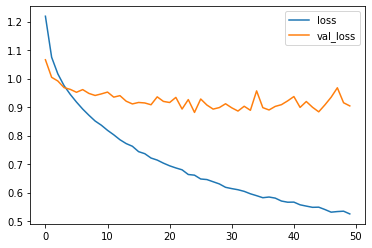

In [31]:
plot(c, 'loss', 'val_loss')

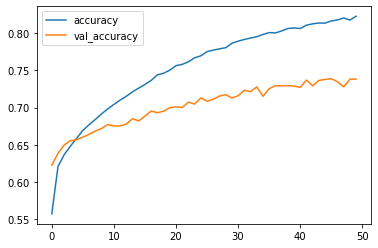

In [32]:
plot(c, 'accuracy', 'val_accuracy')

In [33]:
model.save('model_LSTM1.h5')

In [34]:
import pickle
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [35]:
release_gpu_memory()